<a href="https://colab.research.google.com/github/Resteves147/CSCI_167/blob/main/project_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Fashion-MNIST Clothing Classification**

This notebook explores image classification using the **Fashion-MNIST** dataset, a widely used benchmark containing 70,000 grayscale images of clothing items across 10 categories. Each image is only **28×28 pixels**, making the dataset lightweight but still visually diverse enough to test different deep learning architectures.

The goal of this project is to compare how three models of increasing complexity perform on the same task:

* **MLP (Multilayer Perceptron)** – a simple fully connected baseline
* **SmallCNN** – a lightweight convolutional network
* **DeepCNN** – a deeper CNN with BatchNorm and Dropout

By training each model and analyzing their learning curves, accuracy, and loss, we can understand how architectural choices and hyperparameters affect performance on image recognition tasks.

In [1]:
!pip install torch torchvision

In [2]:
import torch
import torch.nn as nn #building nural network layers
import torch.nn.functional as F # functional  API for activations and some loss functions
from torch.utils.data import DataLoader, random_split # dataloader: creates mini batches and shuffles, random split, splits a data set into train/validation subsets
from torchvision import datasets, transforms #provides common datasets i.e Fashion-MNIST and image transforms

import numpy as np # numpy for numerical operations and seeding
import random #built in random module
import matplotlib.pyplot as plt # plottting training curves and visualizing images

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # choose which device to run on
print("Device:", device)

def set_seed(seed=42): # random seed
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False # disable cuDNN benchmarking
  torch.backends.cudnn.deterministic = True

set_seed(42)

Device: cuda


In [4]:
# Transforms
transform_train = transforms.Compose([ # transform pipline applied to training images
    transforms.RandomCrop(28, padding =2), # randomly crop 28x28 patches with up to 2 pixels of padding
    transforms.RandomHorizontalFlip(), # filp images horizontally with probability 0.5
    transforms.ToTensor(), #convert PIL image to pytorch tensor
    transforms.Normalize((0.5,), (0.5,)) #normalize pixel values
])

transform_test = transforms.Compose([ #tranform pipline for validation/test images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])
# Dataset
full_train = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_train #where to store/download the data,
)
test_set = datasets.FashionMNIST( # test split
    root="./data", train=False, download=True, transform=transform_test
)

train_size = int(0.83 * len(full_train)) # use ~83% of the original train set for training (theres about 50k images)
valid_size = len(full_train) - train_size # the remainder will be used as a validation set
train_set, val_set = random_split(full_train, [train_size, valid_size]) # radomly split the training dataset into train and validation subet

# dataloaders
def make_loaders(batch_size =  64):
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders(batch_size=64)
len(train_loader), len(val_loader), len(test_loader)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.9MB/s]


(779, 160, 157)

#Models: MLP, SmallDCC, DeepCNN


In [5]:
num_classes=10 #number of output classes in Fashion-MNIST

class MLP(nn.Module):
  #simple fully connected neural network,
  # model flattens image into 784 vector and passes through several Linear layers with ReLU + Dropout
  #does not use convolutions, ignores spatial structure
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Flatten(), #flatten image
        nn.Linear(28*28, 256), nn.ReLU(), #first layer
        nn.Dropout(0.2), # prevents overfitting by randomly zeroing activations
        nn.Linear(256, 128), nn.ReLU(), #second hidden layer
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )
  def forward(self, x): #forward pass through the sequential network
    return self.net(x)

In [6]:
class SmallCNN(nn.Module):
  # small convolutional neural network
  # uses 2 Conv2d + ReLU + MaxPool blocks, followed by a fully connected classifier
  # this model can learn simple spatial features (edges and textures)
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # Block 1
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), # Block 2
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [7]:
class DeepCNN(nn.Module):
  #Deeper convolutional neural network
  # Extends SmallCNN with additional conv layers and BatchNorm
  # This increases representational power while keeping training stable
  def __init__(self, num_classes=10):
    super().__init__()
    self.features = nn.Sequential( #block 1
        nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), #block 2
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
    )
    self.classifier = nn.Sequential( #regularization
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
    )
  def forward(self, x):
    x = self.features(x)
    return self.classifier(x)

In [8]:
def count_params(model): #
#count number of trainable parameters in a model
#comparing MLP v SmallCNN v DeepCNN
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

  for Model in [MLP, SmallCNN, DeepCNN]: # check
    m = Model(num_classes).to(device)
    print(Model.__name__,"params:", count_params(m))

In [9]:
from torch.optim.lr_scheduler import StepLR

#train one epoch

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train() #put model in training mode
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device) # move batch to the selected device
        optimizer.zero_grad() #zero out gradients
        logits = model(x) # compute logits
        loss = criterion(logits, y) # comput loss against true labels
        loss.backward() #compute gradients
        optimizer.step() # update parameters

        #accumulate loss and accuracy stats

        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        # returns avg loss: avg training loss over the epoch (running / total)
        # returns avg acc: avg training accuracy over the epoch ( correct /total)
    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
  #evaluate the model on validation
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total


def run_experiment(
    ModelClass,
    optimizer_name="SGD",
    batch_size=64,
    lr=0.01,
    weight_decay=0.0,
    use_scheduler=False,
    epochs=5,
):
    print(f"\n=== {ModelClass.__name__} | opt={optimizer_name}, bs={batch_size}, lr={lr}, wd={weight_decay}, sched={use_scheduler} ===")
    #get dataloaders with chosen batch size
    train_loader, val_loader, test_loader = make_loaders(batch_size)
    #instantiate model and move it to device
    model = ModelClass(num_classes).to(device)
    #cross entropy is standard for multi-class classification
    criterion = nn.CrossEntropyLoss()
    #choose optimizer
    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else: # else Adam
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# optional learning rate schedular (decays LR every few epochs)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1) if use_scheduler else None
# to store learning curves
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
#training loop
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        if scheduler: scheduler.step()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d} | train acc={train_acc:.3f} val acc={val_acc:.3f} | train loss={train_loss:.3f} val loss={val_loss:.3f}")

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Test accuracy: {test_acc:.3f}")

    return model, history, test_acc


In [10]:
# 1) MLP with SGD, no scheduler
mlp_model, mlp_hist, mlp_test = run_experiment(
    MLP,
    optimizer_name="SGD",
    batch_size=64,
    lr=0.1,
    weight_decay=0.0,
    use_scheduler=False,
    epochs=5,
)

# 2) SmallCNN with Adam + StepLR
cnn_model, cnn_hist, cnn_test = run_experiment(
    SmallCNN,
    optimizer_name="Adam",
    batch_size=64,
    lr=1e-3,
    weight_decay=1e-4,
    use_scheduler=True,
    epochs=5,
)

deep_model, deep_hist, deep_test = run_experiment(
    DeepCNN,
    optimizer_name="Adam",
    batch_size=64,
    lr=1e-3,
    weight_decay=1e-4,
    use_scheduler=True,
    epochs=5,
)



=== MLP | opt=SGD, bs=64, lr=0.1, wd=0.0, sched=False ===
Epoch 01 | train acc=0.570 val acc=0.631 | train loss=1.168 val loss=0.988
Epoch 02 | train acc=0.576 val acc=0.587 | train loss=1.176 val loss=1.136
Epoch 03 | train acc=0.564 val acc=0.536 | train loss=1.234 val loss=1.215
Epoch 04 | train acc=0.503 val acc=0.529 | train loss=1.312 val loss=1.172
Epoch 05 | train acc=0.467 val acc=0.491 | train loss=1.347 val loss=1.207
Test accuracy: 0.494

=== SmallCNN | opt=Adam, bs=64, lr=0.001, wd=0.0001, sched=True ===
Epoch 01 | train acc=0.711 val acc=0.805 | train loss=0.779 val loss=0.504
Epoch 02 | train acc=0.795 val acc=0.840 | train loss=0.554 val loss=0.436
Epoch 03 | train acc=0.824 val acc=0.859 | train loss=0.482 val loss=0.381
Epoch 04 | train acc=0.841 val acc=0.870 | train loss=0.436 val loss=0.354
Epoch 05 | train acc=0.855 val acc=0.877 | train loss=0.410 val loss=0.339
Test accuracy: 0.887

=== DeepCNN | opt=Adam, bs=64, lr=0.001, wd=0.0001, sched=True ===
Epoch 01 | t

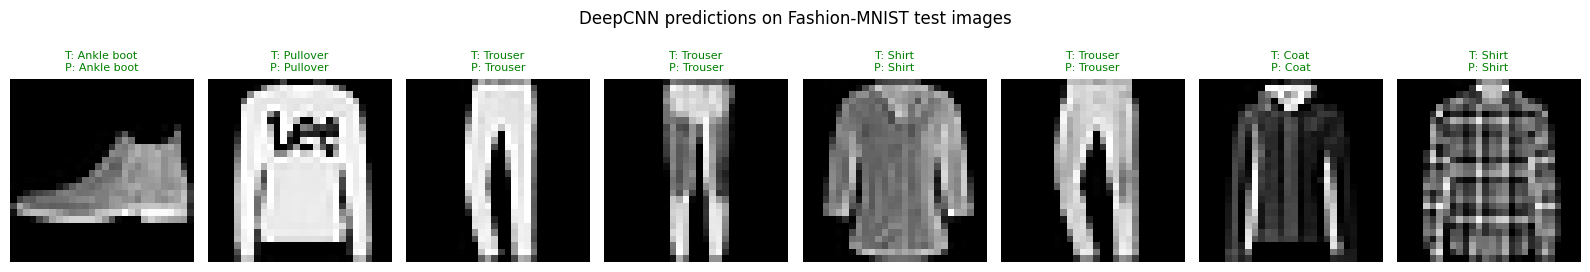

In [11]:
# Class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def show_deepcnn_demo(model, loader, device, n=8):
    """
    Show n test images with DeepCNN's predictions.
    Green title = correct, Red = incorrect.
    """
    model.eval()

    # Grab one batch of images from the test set
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    # Run the model on this batch
    with torch.no_grad():
        logits = model(images)
        preds = logits.argmax(dim=1)

    images = images.cpu()  # move back to CPU for plotting

    # Plot first n images with true & predicted labels
    plt.figure(figsize=(2*n, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = images[i].squeeze(0)  # (1, 28, 28) -> (28, 28)
        ax.imshow(img, cmap="gray")

        true_lbl = class_names[labels[i].item()]
        pred_lbl = class_names[preds[i].item()]

        # Green if correct, red if wrong
        color = "green" if preds[i] == labels[i] else "red"
        ax.set_title(f"T: {true_lbl}\nP: {pred_lbl}", color=color, fontsize=8)
        ax.axis("off")

    plt.suptitle("DeepCNN predictions on Fashion-MNIST test images")
    plt.tight_layout()
    plt.show()

# Call this demo
show_deepcnn_demo(deep_model, test_loader, device, n=8)


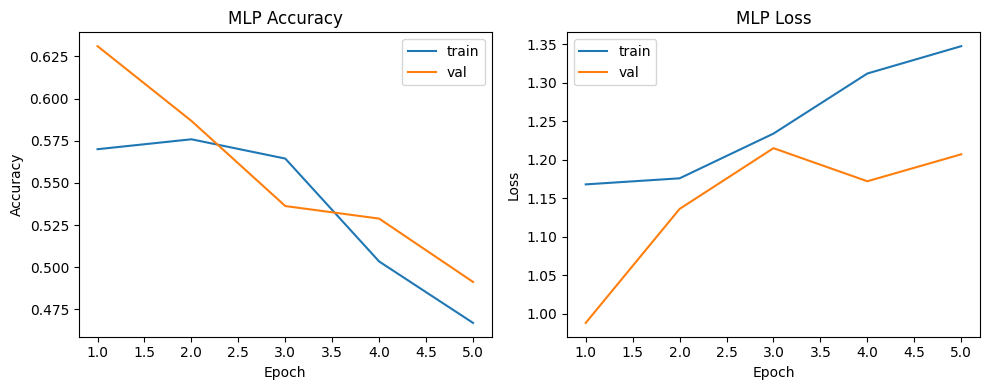

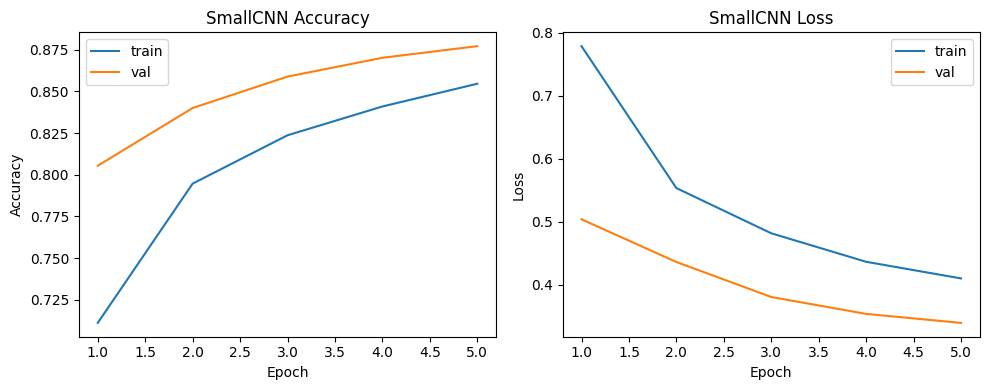

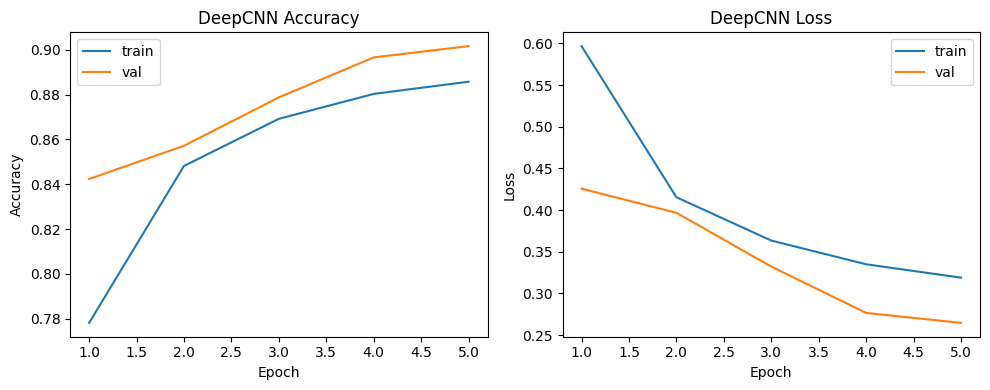

In [12]:
def plot_history(hist, title=""):
    epochs = range(1, len(hist["train_acc"])+1)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, hist["train_acc"], label="train")
    plt.plot(epochs, hist["val_acc"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist["train_loss"], label="train")
    plt.plot(epochs, hist["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(mlp_hist, "MLP")
plot_history(cnn_hist, "SmallCNN")
plot_history(deep_hist, "DeepCNN")
